In [1]:
import os
import sys

sys.path.append('..')

import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import numpy as np
import itertools
import pickle
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, average_precision_score, accuracy_score, roc_curve, auc

In [3]:
# Get the project root directory
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Append the src directory to the Python path
sys.path.append(os.path.join(ROOT_DIR, 'src'))

from preprocessing import GlaucomaDataset

# Declare data directories
train_path = os.path.join(ROOT_DIR, 'raw_data/training_set')
test_path = os.path.join(ROOT_DIR, 'raw_data/test_set')

In [4]:
# Create the GlaucomaDataset instance
dataset = GlaucomaDataset(train_path, test_path)

In [5]:
# Split the training data into train and validation sets
train_data, val_data = dataset.split_train_data(val_size=0.2, random_state=42)

In [6]:
# Get the test data
test_data = dataset.get_test_data()

In [7]:
# Data augmentation and generators
img_size = (256, 256)
batch_size = 32

In [8]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5]
)

valid_datagen = keras.preprocessing.image.ImageDataGenerator()

In [9]:
train_generator = train_datagen.flow_from_dataframe(
    train_data,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    color_mode='rgb',
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary'
)

val_generator = valid_datagen.flow_from_dataframe(
    val_data,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    color_mode='rgb',
    batch_size=batch_size,
    shuffle=False,
    class_mode='binary'
)

Found 248 validated image filenames belonging to 2 classes.
Found 63 validated image filenames belonging to 2 classes.


In [10]:
def build_model():
    base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    predictions = Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01))(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    # Save the trained model
    with open(f'{model_path}/model.pkl', 'wb') as f:
        pickle.dump(model, f)

    model.save(f'{model_path}/model.h5')

    return model

In [11]:
# Create the models directory if it doesn't exist
models_dir = os.path.join(ROOT_DIR, 'models')
os.makedirs(models_dir, exist_ok=True)

model_path = models_dir


# Build the model
model = build_model()

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

# Train the model
epochs = 50
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[early_stopping]
)
    
# # Train the model
# epochs = 20
# history = model.fit(
#     train_generator,
#     epochs=epochs,
#     validation_data=val_generator,
# )



43941136/43941136 [==============================] - 15s 0us/step


c:\Users\Lenovo\miniconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50

8/8 [==============================] - 72s 6s/step - loss: 7.9628 - accuracy: 0.5161 - val_loss: 6.6404 - val_accuracy: 0.7460
Epoch 2/50
8/8 [==============================] - 33s 4s/step - loss: 5.9392 - accuracy: 0.7460 - val_loss: 5.2016 - val_accuracy: 0.6508
Epoch 3/50
8/8 [==============================] - 32s 4s/step - loss: 4.5233 - accuracy: 0.7944 - val_loss: 3.8293 - val_accuracy: 0.8254
Epoch 4/50
8/8 [==============================] - 29s 4s/step - loss: 3.3976 - accuracy: 0.8669 - val_loss: 2.9799 - val_accuracy: 0.8095
Epoch 5/50
8/8 [==============================] - 28s 4s/step - loss: 2.6069 - accuracy: 0.8589 - val_loss: 2.2549 - val_accuracy: 0.8889
Epoch 6/50
8/8 [==============================] - 28s 4s/step - loss: 1.9979 - accuracy: 0.8952 - val_loss: 1.7951 - val_accuracy: 0.8730
Epoch 7/50
8/8 [==============================] - 28s 3s/step - loss: 1.6479 - accuracy: 0.8468 - val_loss: 1.4624 - val_accuracy: 0.8730
Epoch 8/50
8/8 [=================

In [12]:
# Evaluate the model on the test set
test_datagen = keras.preprocessing.image.ImageDataGenerator()
test_generator = test_datagen.flow_from_dataframe(
    test_data,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    color_mode='rgb',
    batch_size=batch_size,
    shuffle=False,
    class_mode='binary'
)

Found 174 validated image filenames belonging to 2 classes.


In [13]:
def plot_roc_curve(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [14]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [15]:
def evaluate_model(model, test_generator):
    # Get predicted probabilities
    y_pred_probs = model.predict(test_generator)

    # Plot ROC curve
    y_true = test_generator.classes
    plot_roc_curve(y_true, y_pred_probs)

    # Get predicted labels
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()

    # Print classification report
    print(classification_report(y_true, y_pred, target_names=['Normal', 'Glaucoma']))

    # Get the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate true positives, true negatives, false positives, and false negatives
    tn, fp, fn, tp = cm.ravel()
    print(f"True Positives: {tp}")
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")

    # Compute ROC AUC
    roc_auc = roc_auc_score(y_true, y_pred_probs)
    print(f"ROC AUC: {roc_auc:.4f}")

    # Calculate AUPRC
    auprc = average_precision_score(y_true, y_pred_probs)
    print(f"AUPRC: {auprc:.4f}")

    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    
    # Plot the confusion matrix
    plot_confusion_matrix(y_true, y_pred, classes=['Normal', 'Glaucoma'], title='Confusion Matrix')

In [16]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

print("Training Accuracy:", train_accuracy[-1])
print("Validation Accuracy:", val_accuracy[-1])

Training Accuracy: 0.9153226017951965
Validation Accuracy: 0.8888888955116272


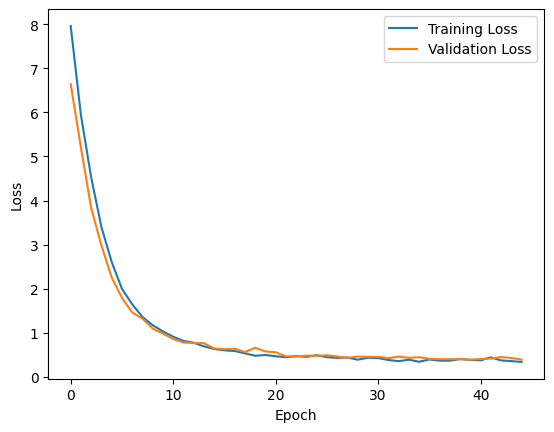

In [17]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

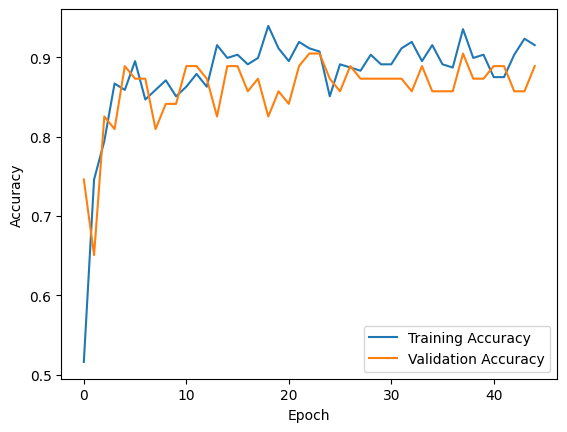

In [19]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [20]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_accuracy:.4f}')

6/6 [==============================] - 16s 2s/step - loss: 0.6370 - accuracy: 0.7644
Test loss: 0.6370
Test accuracy: 0.7644


6/6 [==============================] - 17s 2s/step


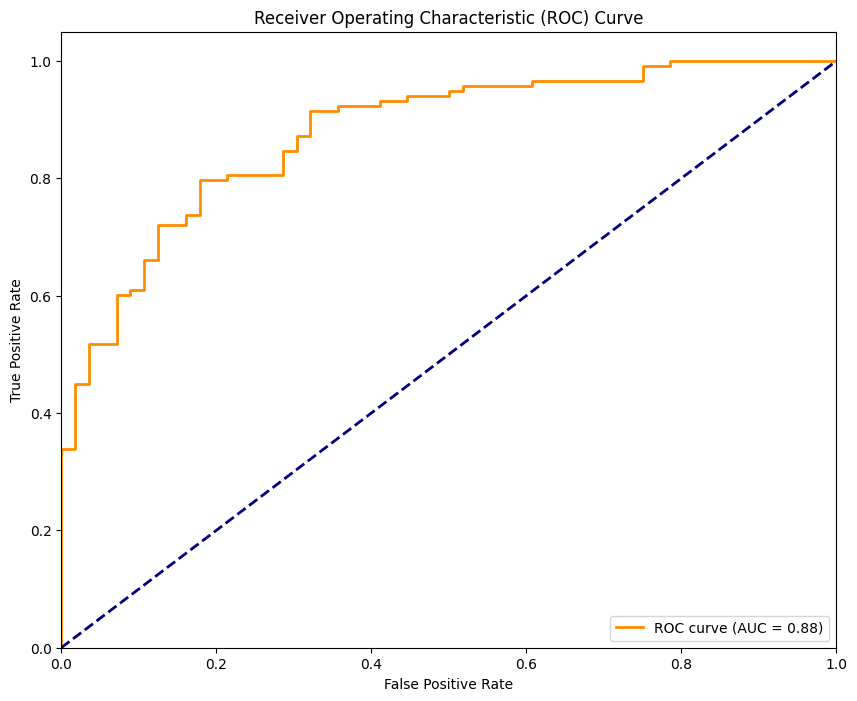

              precision    recall  f1-score   support

      Normal       0.59      0.84      0.70        56
    Glaucoma       0.91      0.73      0.81       118

    accuracy                           0.76       174
   macro avg       0.75      0.78      0.75       174
weighted avg       0.81      0.76      0.77       174

True Positives: 86
True Negatives: 47
False Positives: 9
False Negatives: 32
ROC AUC: 0.8776
AUPRC: 0.9387
Accuracy: 0.7644


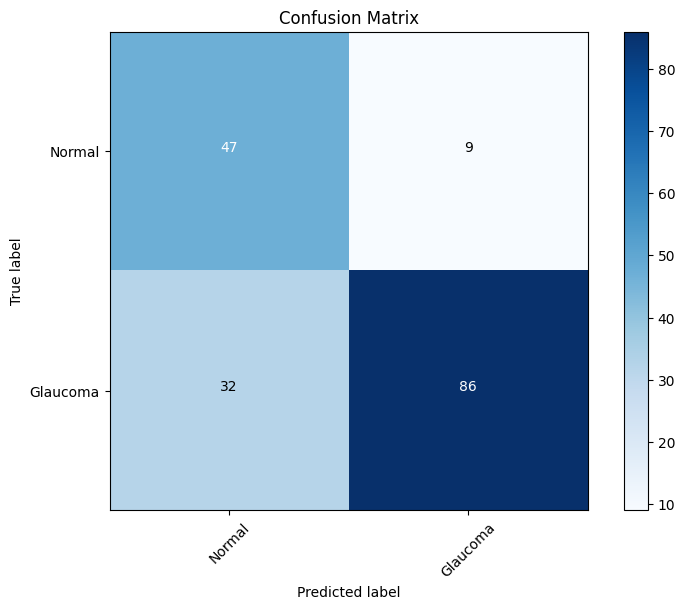

In [21]:
# Evaluate the model on the test set
evaluate_model(model, test_generator)